# Create pileup plots of a specified size around centromeres.
Input two file paths to create a ratio of pileups instead.

In [50]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
import bioframe
import cooler
import cooltools
import cooltools.expected
import cooltools.lib.plotting
from cooltools import snipping

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [51]:
ASSEMBLY = 'sacCer3'
RESOLUTION = 5000
FLANK = 500000
DIR_PATH = ''
COOLER_FILE1 = ''
COOLER_FILE2 = ''
CEN_FILE = ''
TITLE = ''
OUT_PATH = ''

COOLER_PATHS = [
    '',
    ''
]

In [52]:
# get chromsizes, centromeres, arms
chromsizes = bioframe.fetch_chromsizes(ASSEMBLY, filter_chroms=False, as_bed=True)
centromeres = pd.read_csv(CEN_FILE, delim_whitespace=True, header=None, names=['chrom', 'start', 'end', 'mid'])
centromeres['mid'] = centromeres.apply(lambda row: (row['start'] + row['end']) // 2, axis=1)
arms = bioframe.split(chromsizes, centromeres, cols_points=['chrom', 'mid'])

In [53]:
def pileup(clr):
    windows = snipping.make_bin_aligned_windows(
        RESOLUTION,
        centromeres['chrom'],
        centromeres['mid'],
        flank_bp=FLANK
    )
    supports = chromsizes[['chrom', 'start', 'end']].values
    windows = snipping.assign_regions(windows, supports)

    snipper = cooltools.snipping.CoolerSnipper(clr)

    stack = cooltools.snipping.pileup(
        windows,
        snipper.select,
        snipper.snip
    )

    mtx = np.nanmean(stack, axis=2)
    return mtx

In [54]:
clrs = []
for path in COOLER_PATHS:
    clrs.append(cooler.Cooler(os.path.join(DIR_PATH, '::/resolutions/'.join((path, str(RESOLUTION))))))

stacks = [pileup(clr) for clr in clrs]

/users/sebastian.rusch/.conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/users/sebastian.rusch/.conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


array([-500, -250,    0,  250,  500])

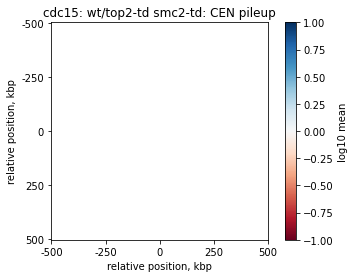

In [55]:
# variables for single pileup
vmax = -3.75
vmin = -1.75
cmap = 'fall'

if len(stacks) == 2:
    # variables for pileup ratio
    stacks[0] = stacks[0] / stacks[1]
    vmax = 1
    vmin = -1
    cmap = 'RdBu'

plt.imshow(
    np.log10(stacks[0]),
    vmax=vmax,
    vmin=vmin,
    cmap=cmap
)
plt.colorbar(label='log10 mean')
ticks_pixels = np.linspace(0, FLANK * 2 // RESOLUTION, 5)
ticks_kbp = ((ticks_pixels - ticks_pixels[-1] / 2) * RESOLUTION // 1000).astype(int)
display(ticks_kbp)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')
plt.title(TITLE)

plt.savefig(OUT_PATH, dpi=300)